<span style="font-width:bold; font-size: 3rem; color:#333;">- Batch Inference</span>

In [18]:
import sys
from pathlib import Path

#Find root directory
root_dir = Path().absolute()
if root_dir.parts[-2:] == ('notebooks', 'algae_bloom'):
    root_dir = Path(*root_dir.parts[:-2])
root_dir = str(root_dir)

print(f"Root dir: {root_dir}")

# Add the root directory to the `PYTHONPATH` 
if root_dir not in sys.path:
    sys.path.append(root_dir)
    print(f"Added the following directory to the PYTHONPATH: {root_dir}")

Root dir: /Users/kevinkokalari/Documents/Skalbar Maskininlärning och Djupinlärning/Laborationer/id2223-project
Added the following directory to the PYTHONPATH: /Users/kevinkokalari/Documents/Skalbar Maskininlärning och Djupinlärning/Laborationer/id2223-project


## Clear old saved predictions

In [ ]:
from pathlib import Path

root = (Path(root_dir) / "docs" / "water-temp").resolve()

print("Using:", root)
print(root.is_dir())
assert root.is_dir() and root.name == "water-temp"

# Delete files only in subdirectories (not in water-temp root)
for subdir in root.iterdir():
    if subdir.is_dir():
        for p in subdir.rglob("*"):
            if p.is_file() or p.is_symlink():
                p.unlink()

Using: /Users/kevinkokalari/Documents/Skalbar Maskininlärning och Djupinlärning/Laborationer/id2223-project/docs/water-temp
True


## 🌐 Imports

In [ ]:
import datetime
import pandas as pd
#from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import hopsworks
import json
from mlfs.airquality import util
import os
import numpy as np

In [17]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2026, 1, 2, 18, 49, 25, 673570)

## 🌳 Connect to Hopsworks and get variables from Hopsworks secret </span>

In [18]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()

#Get the dictionary with all batch locations
bath_locations_json = secrets.get_secret("BATH_LOCATIONS_JSON").value
bath_locations = json.loads(bath_locations_json)
print(bath_locations)

2026-01-02 18:49:27,476 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-02 18:49:27,490 INFO: Initializing external client
2026-01-02 18:49:27,491 INFO: Base URL: https://c.app.hopsworks.ai:443


ProjectException: Could not find project kokalari

## ⚓︎ Download model from model registry

In [5]:
mr = project.get_model_registry()

#Retrieve model from Hopsworks
model_version = 3

retrieved_model = mr.get_model(
    name="water_temperature_catboost_model", 
    version=model_version, 
)
fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-12-29 00:50:33,101 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/528801 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/1118520 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/43686 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/73466 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/70834 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/76661 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/62828 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/69319 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/122505 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/130739 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26824 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/87262 elapsed<00:00 remaining<?

In [6]:
# Loading the regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")

#retrieved_xgboost_model = XGBRegressor()
retrieved_catboost_model = CatBoostRegressor()

#retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")
retrieved_catboost_model.load_model(saved_model_dir + "/model.cbm")

# Displaying the retrieved regressor model
#retrieved_xgboost_model
retrieved_catboost_model

## ☔️ Get the weather forecast features from the feature view



In [7]:
#Select version of feature group
w_version = 1

weather_fg = fs.get_feature_group(
    name='weather',
    version=w_version,
)
batch_data = weather_fg.filter(weather_fg.formatted_time >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.99s) 


,formatted_time,alias,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m,shortwave_radiation_sum_yday,sunshine_duration_yday,latitude,longitude
0,2026-01-01 12:00:00+00:00,Mälarbadet,0.70,3.4,31.122828,150.173004,0.19,0.000000,59.222657,17.611886
1,2026-01-02 12:00:00+00:00,Mälarbadet,0.20,0.7,9.449572,17.744766,0.46,0.000000,59.222657,17.611886
2,2025-12-31 12:00:00+00:00,Mälarbadet,-4.25,0.0,7.280550,8.530692,1.37,1.859202,59.222657,17.611886
3,2025-12-30 12:00:00+00:00,Mälarbadet,-2.15,0.0,28.916763,341.113800,1.41,1.831642,59.222657,17.611886
4,2025-12-29 12:00:00+00:00,Mälarbadet,-0.75,0.0,25.499081,300.547485,1.30,1.805782,59.222657,17.611886


## 🔮 Add lagging features for comming days using predictions  </span>


In [8]:
#Select version of feature group
BATH_TO_CODE = {"Bergabadet":0,"Bränningestrand":1,"Eklundsnäsbadet":2,"Farstanäsbadet":3, "Mälarbadet":4, "Nya Malmsjöbadet":5, "Näsets udde(Glashyttan)":6, "Underåsbadet":7, "Åbynäsbadet":8}
CODE_TO_BATH = {0:"Bergabadet", 1:"Bränningestrand", 2:"Eklundsnäsbadet", 3:"Farstanäsbadet", 4:"Mälarbadet", 5:"Nya Malmsjöbadet", 6:"Näsets udde(Glashyttan)", 7:"Underåsbadet", 8:"Åbynäsbadet"}

wt_version = 1

water_temperature_fg = fs.get_feature_group(
    name='water_temperature',
    version=wt_version,
)
batch_data = batch_data.sort_values("formatted_time").reset_index(drop=True)



batch_data_frames = []
for location_dict in bath_locations:
    bath_location = location_dict['bath_location']
    print(bath_location)

    bath_location_cat = BATH_TO_CODE[bath_location]

    #wt_df = water_temperature_fg.filter(water_temperature_fg.alias == bath_location)
    wt_df = water_temperature_fg.read()
    wt_df = wt_df[wt_df['alias'] == bath_location]
    wt_df = wt_df.sort_values("formatted_time")
    if bath_location == "Mälarbadet":
        print(wt_df)

    #print(wt_df)

    temp_batch_data = batch_data[batch_data["alias"] == bath_location].copy().reset_index(drop=True)
    temp_batch_data["alias"] = temp_batch_data["alias"].map(BATH_TO_CODE)

    for i in range (temp_batch_data.shape[0]):
        if i == 0:
            lagged1_df = wt_df[
                pd.to_datetime(wt_df["formatted_time"]).dt.date
                == (pd.to_datetime(temp_batch_data.iloc[i]["formatted_time"]).date() - datetime.timedelta(days=1))
            ]
            lagged2_df = wt_df[
                pd.to_datetime(wt_df["formatted_time"]).dt.date
                == (pd.to_datetime(temp_batch_data.iloc[i]["formatted_time"]).date() - datetime.timedelta(days=2))
            ]
            lagged3_df = wt_df[
                pd.to_datetime(wt_df["formatted_time"]).dt.date
                == (pd.to_datetime(temp_batch_data.iloc[i]["formatted_time"]).date() - datetime.timedelta(days=3))
            ]
            #print(lagged1_df)
            #print(lagged2_df)
            #print(lagged3_df)

            if not lagged1_df.empty:
                temp_batch_data.loc[i, "lagged_wt_1_day"] = lagged1_df["temp_water"].values[-1]
            else:
                temp_batch_data.loc[i, "lagged_wt_1_day"] = 'NaN'
            if not lagged2_df.empty:
                temp_batch_data.loc[i, "lagged_wt_2_days"] = lagged2_df["temp_water"].values[-1]
            else:
                temp_batch_data.loc[i, "lagged_wt_2_days"] = 'NaN'
            if not lagged3_df.empty:
                temp_batch_data.loc[i,"lagged_wt_3_days"] = lagged3_df["temp_water"].values[-1]
            else:
                temp_batch_data.loc[i, "lagged_wt_3_days"] = 'NaN'

        elif i==1:
            temp_batch_data.loc[i, "lagged_wt_1_day"] = temp_batch_data.iloc[i-1]['predicted_temp_water']
            
            lagged2_df = wt_df[pd.to_datetime(wt_df["formatted_time"]).dt.date== (pd.to_datetime(temp_batch_data.iloc[i]["formatted_time"]).date() -datetime.timedelta(days=2))]
            lagged3_df = wt_df[pd.to_datetime(wt_df["formatted_time"]).dt.date== (pd.to_datetime(temp_batch_data.iloc[i]["formatted_time"]).date() -datetime.timedelta(days=3))]
            
            if not lagged2_df.empty:
                temp_batch_data.loc[i, "lagged_wt_2_days"] = lagged2_df["temp_water"].values[0]
            else:
                temp_batch_data.loc[i, "lagged_wt_2_days"] = 'NaN'
            if not lagged3_df.empty:
                temp_batch_data.loc[i,"lagged_wt_3_days"] = lagged3_df["temp_water"].values[0]
            else:
                temp_batch_data.loc[i, "lagged_wt_3_days"] = 'NaN'

        elif i==2:
            temp_batch_data.loc[i, "lagged_wt_1_day"] = temp_batch_data.iloc[i-1]['predicted_temp_water']
            temp_batch_data.loc[i, "lagged_wt_2_days"] = temp_batch_data.iloc[i-2]['predicted_temp_water']
            
            lagged3_df = wt_df[pd.to_datetime(wt_df["formatted_time"]).dt.date == (pd.to_datetime(temp_batch_data.iloc[i]["formatted_time"]).date() -datetime.timedelta(days=3))]
            
            if not lagged3_df.empty:
                temp_batch_data.loc[i,"lagged_wt_3_days"] = lagged3_df["temp_water"].values[0]
            else:
                temp_batch_data.loc[i, "lagged_wt_3_days"] = 'NaN'
            
        else:
            temp_batch_data.loc[i, "lagged_wt_1_day"] = temp_batch_data.iloc[i-1]['predicted_temp_water']
            temp_batch_data.loc[i, "lagged_wt_2_days"] = temp_batch_data.iloc[i-2]['predicted_temp_water']
            temp_batch_data.loc[i, "lagged_wt_3_days"] = temp_batch_data.iloc[i-3]['predicted_temp_water']

        temp_batch_data['lagged_wt_1_day'] = temp_batch_data['lagged_wt_1_day'].astype(float)
        temp_batch_data['lagged_wt_2_days'] = temp_batch_data['lagged_wt_2_days'].astype(float)
        temp_batch_data['lagged_wt_3_days'] = temp_batch_data['lagged_wt_3_days'].astype(float)
        temp_batch_data.loc[i,'predicted_temp_water'] = retrieved_catboost_model.predict(
        temp_batch_data[['alias', 'lagged_wt_1_day','lagged_wt_2_days', 'lagged_wt_3_days','temperature_2m', 'precipitation', 'wind_speed_10m', 'wind_direction_10m', 'shortwave_radiation_sum_yday', 'sunshine_duration_yday']])[i]
        temp_batch_data.loc[i,'predicted_temp_water'] = temp_batch_data.loc[i,'predicted_temp_water'].astype(np.float32)
    
    
    print(temp_batch_data)
    batch_data_frames.append(temp_batch_data)
    



Bergabadet
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.17s) 
Empty DataFrame
Columns: [formatted_time, alias, temperature_2m, precipitation, wind_speed_10m, wind_direction_10m, shortwave_radiation_sum_yday, sunshine_duration_yday, latitude, longitude]
Index: []
Bränningestrand
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.93s) 
Empty DataFrame
Columns: [formatted_time, alias, temperature_2m, precipitation, wind_speed_10m, wind_direction_10m, shortwave_radiation_sum_yday, sunshine_duration_yday, latitude, longitude]
Index: []
Eklundsnäsbadet
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.93s) 
Empty DataFrame
Columns: [formatted_time, alias, temperature_2m, precipitation, wind_speed_10m, wind_direction_10m, shortwave_radiation_sum_yday, sunshine_duration_yday, latitude, longitude]
Index: []
Farstanäsbadet
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.7

In [9]:
batch_data_frames[4]

,formatted_time,alias,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m,shortwave_radiation_sum_yday,sunshine_duration_yday,latitude,longitude,lagged_wt_1_day,lagged_wt_2_days,lagged_wt_3_days,predicted_temp_water
0,2025-12-29 12:00:00+00:00,4,-0.75,0.0,25.499081,300.547485,1.30,1.805782,59.222657,17.611886,4.800000,5.200000,5.100000,4.674108
1,2025-12-30 12:00:00+00:00,4,-2.15,0.0,28.916763,341.113800,1.41,1.831642,59.222657,17.611886,4.674108,4.800000,5.200000,4.296947
2,2025-12-31 12:00:00+00:00,4,-4.25,0.0,7.280550,8.530692,1.37,1.859202,59.222657,17.611886,4.296947,4.674108,4.800000,4.099709
3,2026-01-01 12:00:00+00:00,4,0.70,3.4,31.122828,150.173004,0.19,0.000000,59.222657,17.611886,4.099709,4.296947,4.674108,2.910950
4,2026-01-02 12:00:00+00:00,4,0.20,0.7,9.449572,17.744766,0.46,0.000000,59.222657,17.611886,2.910950,4.099709,4.296947,3.236399


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [10]:
if False:
    batch_data['predicted_temp_water'] = retrieved_xgboost_model.predict(
        batch_data[['temperature_2m', 'precipitation', 'wind_speed_10m', 'wind_direction_10m']])
    batch_data

In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype                  
---  ------                        --------------  -----                  
 0   formatted_time                5 non-null      datetime64[us, Etc/UTC]
 1   alias                         5 non-null      object                 
 2   temperature_2m                5 non-null      float32                
 3   precipitation                 5 non-null      float32                
 4   wind_speed_10m                5 non-null      float32                
 5   wind_direction_10m            5 non-null      float32                
 6   shortwave_radiation_sum_yday  5 non-null      float32                
 7   sunshine_duration_yday        5 non-null      float32                
 8   latitude                      5 non-null      float64                
 9   longitude                     5 non-null      float64                

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [12]:


k=0
for batch_df in batch_data_frames:
    print(batch_df["alias"])
    #batch_df['street'] = locations[k]['street']
    #batch_df['city'] = city
    #batch_df['country'] = country
    # Fill in the number of days before the date on which you made the forecast (base_date)
    batch_df = batch_df.sort_values(by=['formatted_time']) #OBS har ändrat ordning för blev helt fel med antal dagar innan annars
    batch_df['days_before_forecast_day'] = range(1, len(batch_df)+1)
    batch_data_frames[k] = batch_df
        
    k+=1

#batch_data_frames[5]

Series([], Name: alias, dtype: int64)
Series([], Name: alias, dtype: int64)
Series([], Name: alias, dtype: int64)
Series([], Name: alias, dtype: int64)
0    4
1    4
2    4
3    4
4    4
Name: alias, dtype: int64
Series([], Name: alias, dtype: int64)
Series([], Name: alias, dtype: int64)
Series([], Name: alias, dtype: int64)
Series([], Name: alias, dtype: int64)


In [13]:
   
batch_data_frames[5].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype                  
---  ------                        --------------  -----                  
 0   formatted_time                0 non-null      datetime64[us, Etc/UTC]
 1   alias                         0 non-null      int64                  
 2   temperature_2m                0 non-null      float32                
 3   precipitation                 0 non-null      float32                
 4   wind_speed_10m                0 non-null      float32                
 5   wind_direction_10m            0 non-null      float32                
 6   shortwave_radiation_sum_yday  0 non-null      float32                
 7   sunshine_duration_yday        0 non-null      float32                
 8   latitude                      0 non-null      float64                
 9   longitude                     0 non-null      float64                
 10  da

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

4
Mälarbadet


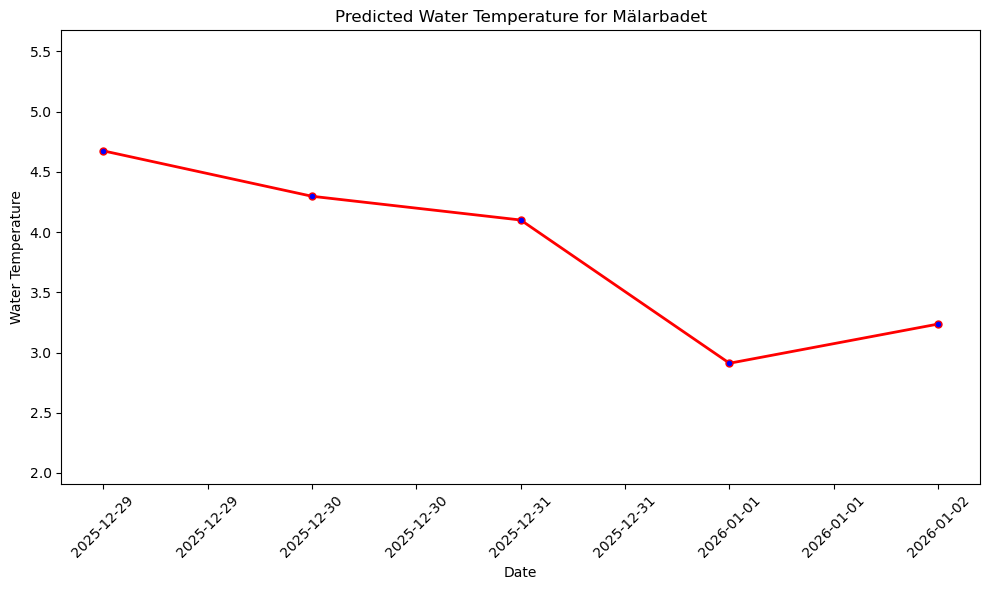

In [14]:



for batch_df in batch_data_frames:
    if batch_df["alias"].size == 0:
        continue
    place_code = batch_df['alias'][0]
    print(place_code)
    bath_name = CODE_TO_BATH[place_code]
    #batch_df["alias"] = bath_name

    print(bath_name)
    pred_file_path = f"{root_dir}/docs/water-temp/water-temp_{bath_name}/assets/img/water_temp_forecast_{bath_name}.png"
    plt = util.plot_water_temp_forecast(bath_name, batch_df, pred_file_path)

    plt.show()

In [15]:
# Get or create feature group

#Select version of feature group

m_version = 1


monitor_fg = fs.get_or_create_feature_group(
    name='wt_predictions',
    description='Water Temperature prediction monitoring',
    version=m_version,
    primary_key=['alias','formatted_time','days_before_forecast_day'],
    event_time="formatted_time"
)

In [16]:

all_data_frames = None
for frame in batch_data_frames:
    if all_data_frames is None:
        all_data_frames = frame
    else:
        all_data_frames = pd.concat([all_data_frames,frame], ignore_index=True)
all_data_frames["predicted_temp_water"] = all_data_frames["predicted_temp_water"].astype(np.float32)
monitor_fg.insert(all_data_frames, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 5/5 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: wt_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286295/jobs/named/wt_predictions_1_offline_fg_materialization/executions
2025-12-29 00:51:18,882 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-12-29 00:51:25,281 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-12-29 00:53:24,161 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-12-29 00:53:24,330 INFO: Waiting for log aggregation to finish.
2025-12-29 00:53:43,177 INFO: Execution finished successfully.


(Job('wt_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [17]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.17s) 


,formatted_time,alias,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m,shortwave_radiation_sum_yday,sunshine_duration_yday,latitude,longitude,days_before_forecast_day,lagged_wt_1_day,lagged_wt_2_days,lagged_wt_3_days,predicted_temp_water
0,2025-12-29 12:00:00+00:00,4,-0.750000,0.0,25.499081,300.547485,1.300000,1.805782,59.222657,17.611886,1,4.8,5.2,5.1,4.674108
1,2025-06-16 11:06:00+00:00,0,19.200001,0.0,14.743526,252.228592,14.490000,7.187217,59.057008,17.440774,1,19.6,18.4,18.0,19.108622
2,2025-06-15 11:06:00+00:00,0,24.750000,0.0,13.169555,190.234741,26.900000,14.897076,59.057008,17.440774,1,18.4,18.0,16.9,19.386852
3,2025-06-23 11:08:00+00:00,0,15.500000,0.0,20.352739,177.972717,10.920000,1.635871,59.057008,17.440774,1,19.8,19.4,19.3,19.106525
4,2025-06-19 11:06:00+00:00,0,17.450001,0.0,21.661411,334.925598,23.520000,12.698011,59.057008,17.440774,1,19.6,20.8,20.8,19.158224
5,2025-06-17 11:06:00+00:00,0,22.250000,0.0,18.057508,274.573822,22.180000,15.880381,59.057008,17.440774,1,20.8,19.6,18.4,20.821520
6,2025-06-18 11:06:00+00:00,0,19.950001,0.0,17.448862,312.909821,25.000000,15.937278,59.057008,17.440774,1,20.8,20.8,19.6,20.632032
7,2025-06-22 11:06:00+00:00,0,18.500000,0.0,3.640275,8.530692,27.760000,15.396276,59.057008,17.440774,1,19.4,19.3,19.4,19.357107
8,2025-06-21 11:06:00+00:00,0,21.049999,0.0,18.000898,319.460938,25.639999,16.014751,59.057008,17.440774,1,19.3,19.4,19.6,19.697205
9,2025-06-20 11:06:00+00:00,0,17.700001,0.0,18.532135,330.945496,21.920000,12.884619,59.057008,17.440774,1,19.4,19.6,20.8,19.083120


In [18]:
#Select version of feature group

wt_version = 1
    
water_temperature_fg = fs.get_feature_group(name='water_temperature', version=wt_version)
water_temperature_df = water_temperature_fg.read()
water_temperature_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.06s) 


,formatted_time,alias,temp_water,longitude,latitude,lagged_wt_1_day,lagged_wt_2_days,lagged_wt_3_days
0,2025-02-27 13:53:00+00:00,Åbynäsbadet,2.0,17.619576,59.018397,1.9,1.7,1.7
1,2022-10-26 10:40:00+00:00,Eklundsnäsbadet,8.3,17.591840,59.168830,11.3,8.4,5.3
2,2022-07-22 11:44:00+00:00,Bränningestrand,20.8,17.667400,59.148617,20.4,18.9,18.8
3,2022-12-11 10:11:00+00:00,Farstanäsbadet,3.9,17.653870,59.096884,4.0,5.0,4.4
4,2024-06-30 14:45:00+00:00,Farstanäsbadet,20.2,17.653870,59.096884,21.4,21.4,21.0
...,...,...,...,...,...,...,...,...
7413,2023-09-18 10:52:00+00:00,Bränningestrand,15.6,17.667400,59.148617,16.8,16.9,16.1
7414,2022-09-11 11:45:00+00:00,Mälarbadet,17.0,17.611886,59.222657,17.2,17.9,18.4
7415,2023-03-30 10:32:00+00:00,Näsets udde(Glashyttan),1.6,17.660720,59.158419,1.2,1.9,2.2
7416,2023-02-13 09:49:00+00:00,Eklundsnäsbadet,3.6,17.591840,59.168830,3.4,3.3,3.0


In [19]:
def backfill_predictions_for_monitoring(weather_fg, water_temp_df, monitor_fg, model):
    features_df = weather_fg.read()
    features_df["alias"] = features_df["alias"].map(BATH_TO_CODE).astype("Int64")

    print(features_df)
    all_features_df = pd.merge(
        water_temp_df[['lagged_wt_1_day','lagged_wt_2_days', 'lagged_wt_3_days', 'formatted_time', 'alias']],
        features_df[['temperature_2m', 'precipitation', 'wind_speed_10m', 'wind_direction_10m', 'shortwave_radiation_sum_yday','sunshine_duration_yday', 'latitude', 'longitude', 'formatted_time', 'alias']],
        on=['formatted_time', 'alias'],
    )
    all_features_df = all_features_df.sort_values(by=['formatted_time'], ascending=True)
    all_features_df = all_features_df.tail(10)



    #street = water_temp_df.iloc[0]['alias']
    #all_features_df.rename(columns={'temperature_2m_mean' : 'weather_temperature_2m_mean', 'precipitation_sum' : 'weather_precipitation_sum','wind_speed_10m_max' : 'weather_wind_speed_10m_max', 'wind_direction_10m_dominant' : 'weather_wind_direction_10m_dominant'}, inplace=True)

    X = all_features_df[[
        "alias",
        "lagged_wt_1_day", "lagged_wt_2_days", "lagged_wt_3_days",
        "temperature_2m", "precipitation", "wind_speed_10m", "wind_direction_10m",
        "shortwave_radiation_sum_yday", "sunshine_duration_yday",
    ]]



    all_features_df['predicted_temp_water'] = model.predict(X)

    all_features_df['predicted_temp_water'] = all_features_df['predicted_temp_water'].astype(np.float32)
    
    df = pd.merge(all_features_df, water_temp_df[['formatted_time','temp_water','alias']], on=["formatted_time", "alias"])
    df['days_before_forecast_day'] = 1
    hindcast_df = df
    df = df.drop('temp_water', axis=1)
    
    df
       
    monitor_fg.insert(df, wait=True)

    return hindcast_df
    



In [ ]:




outcome_df = water_temperature_df[['formatted_time', 'temp_water', 'alias']].copy()
#print()
outcome_df["alias"] = outcome_df["alias"].map(BATH_TO_CODE)
preds_df =  monitoring_df[['formatted_time', 'predicted_temp_water', 'alias']]

hindcast_df = pd.merge(preds_df, outcome_df, on=['formatted_time', 'alias'])    
    
hindcast_dfs = []
for location in bath_locations:
        print(location)
        sensor_hindcast_df = hindcast_df[hindcast_df['alias'] == BATH_TO_CODE[location['bath_location']]]
        sensor_wt_df = water_temperature_df[water_temperature_df['alias'] == location['bath_location']].copy()
        sensor_wt_df["alias"] = BATH_TO_CODE[location["bath_location"]]
        
        sensor_hindcast_df = sensor_hindcast_df.sort_values(by=['formatted_time'])

        # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
        if sensor_hindcast_df.empty:
            print(sensor_wt_df)
            sensor_hindcast_df = backfill_predictions_for_monitoring(weather_fg, sensor_wt_df, monitor_fg, retrieved_catboost_model)
        
        hindcast_dfs.append(sensor_hindcast_df)

#hindcast_dfs[1]

2025-12-29 00:53:47,516 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

{'bath_location': 'Bergabadet', 'latitude': 59.057008, 'longitude': 17.440774}
2025-12-29 00:53:47,521 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

                formatted_time  alias  temp_water  longitude   latitude  \
11   2024-06-15 14:28:00+00:00      0        18.5  17.440774  59.057008   
12   2023-01-01 10:01:00+00:00      0         2.4  17.440774  59.057008   
41   2022-08-18 12:04:00+00:00      0        23.3  1

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: wt_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286295/jobs/named/wt_predictions_1_offline_fg_materialization/executions
2025-12-29 00:54:19,456 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-12-29 00:54:25,889 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-12-29 00:54:35,507 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-12-29 00:56:44,023 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-12-29 00:56:44,193 INFO: Waiting for log aggregation to finish.
2025-12-29 00:56:52,813 INFO: Execution finished successfully.
{'bath_location': 'Bränningestrand', 'latitude': 59.148617, 'longitude': 17.6674}
2025-12-29 00:56:52,818 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: wt_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286295/jobs/named/wt_predictions_1_offline_fg_materialization/executions
2025-12-29 00:57:23,824 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-12-29 00:57:33,665 INFO: Waiting for log aggregation to finish.
2025-12-29 00:59:44,570 ERROR: Execution failed with status: FAILED. See the logs for more information.
{'bath_location': 'Eklundsnäsbadet', 'latitude': 59.16883, 'longitude': 17.59184}
2025-12-29 00:59:44,577 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

                formatted_time  alias  temp_water  longitude  latitude  \
1    2022

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: wt_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286295/jobs/named/wt_predictions_1_offline_fg_materialization/executions
2025-12-29 01:00:19,041 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-12-29 01:00:22,272 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-12-29 01:00:25,484 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-12-29 01:02:21,604 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-12-29 01:02:21,767 INFO: Waiting for log aggregation to finish.
2025-12-29 01:02:30,449 INFO: Execution finished successfully.
{'bath_location': 'Farstanäsbadet', 'latitude': 59.096884, 'longitude': 17.65387}
2025-12-29 01:02:30,458 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: wt_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286295/jobs/named/wt_predictions_1_offline_fg_materialization/executions
2025-12-29 01:03:27,205 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-12-29 01:03:36,869 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-12-29 01:03:46,535 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-12-29 01:05:30,051 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-12-29 01:05:30,212 INFO: Waiting for log aggregation to finish.
2025-12-29 01:05:42,326 INFO: Execution finished successfully.
{'bath_location': 'Mälarbadet', 'latitude': 59.222657, 'longitude': 17.611886}
2025-12-29 01:05:42,332 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: wt_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286295/jobs/named/wt_predictions_1_offline_fg_materialization/executions
2025-12-29 01:06:21,113 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-12-29 01:06:27,581 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: FAILED
2025-12-29 01:06:27,752 INFO: Waiting for log aggregation to finish.
2025-12-29 01:08:42,338 ERROR: Execution failed with status: FAILED. See the logs for more information.
{'bath_location': 'Nya Malmsjöbadet', 'latitude': 59.234823, 'longitude': 17.536534}
2025-12-29 01:08:42,357 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: wt_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286295/jobs/named/wt_predictions_1_offline_fg_materialization/executions
2025-12-29 01:09:19,978 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-12-29 01:09:26,425 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-12-29 01:11:22,863 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-12-29 01:11:23,031 INFO: Waiting for log aggregation to finish.
2025-12-29 01:11:31,696 INFO: Execution finished successfully.
{'bath_location': 'Näsets udde(Glashyttan)', 'latitude': 59.158419, 'longitude': 17.66072}
2025-12-29 01:11:31,708 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: wt_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286295/jobs/named/wt_predictions_1_offline_fg_materialization/executions
2025-12-29 01:12:22,171 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-12-29 01:12:25,389 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-12-29 01:12:31,847 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-12-29 01:14:34,712 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-12-29 01:14:34,882 INFO: Waiting for log aggregation to finish.
2025-12-29 01:14:43,547 INFO: Execution finished successfully.
{'bath_location': 'Underåsbadet', 'latitude': 59.26482, 'longitude': 17.536534}
2025-12-29 01:14:43,560 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: wt_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286295/jobs/named/wt_predictions_1_offline_fg_materialization/executions
2025-12-29 01:15:19,669 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-12-29 01:15:29,366 INFO: Waiting for execution to finish. Current state: FAILED. Final status: FAILED
2025-12-29 01:15:29,566 INFO: Waiting for log aggregation to finish.


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

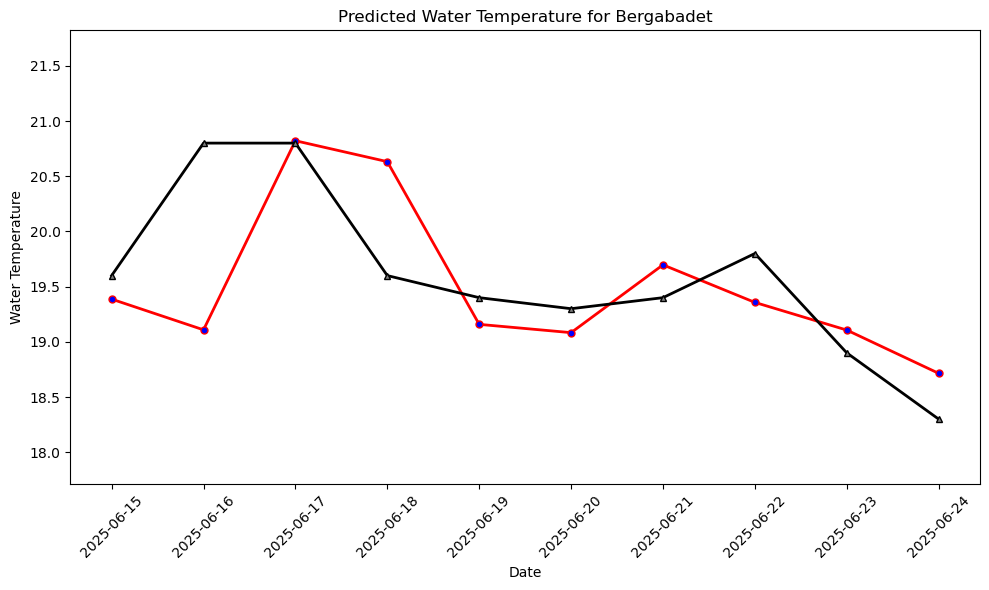

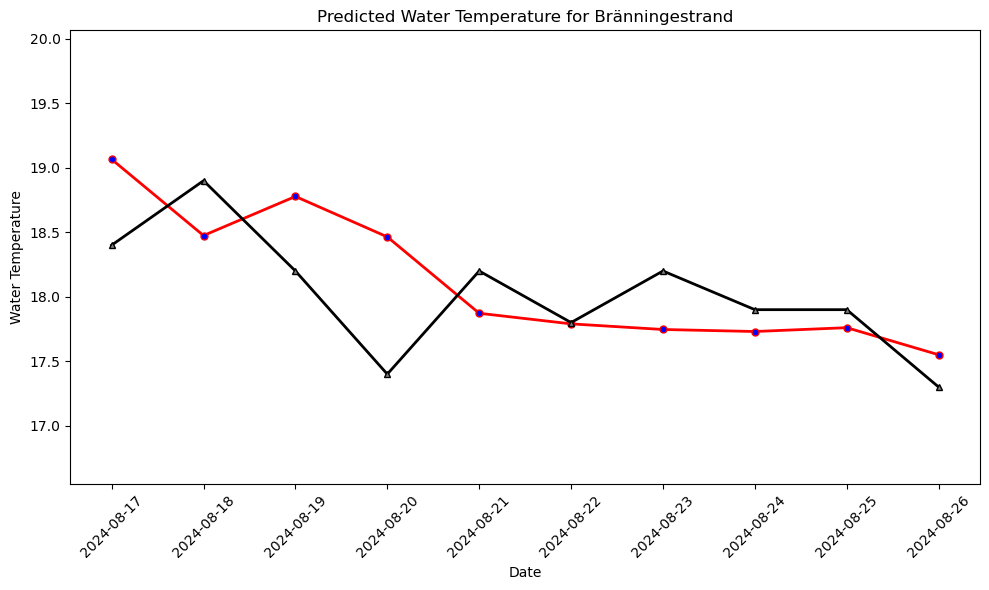

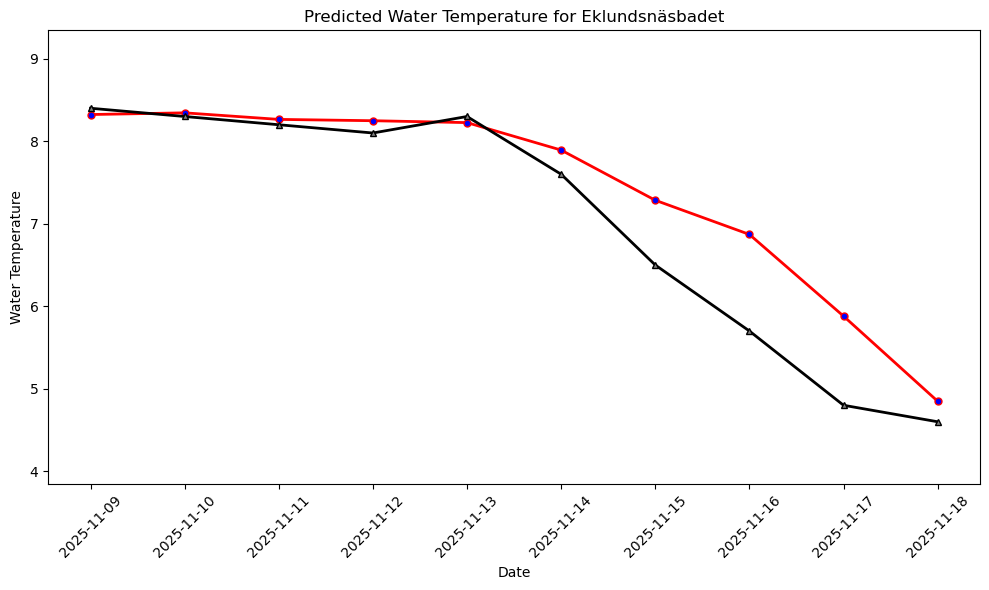

In [ ]:


for h_df in hindcast_dfs:
        place_code = h_df.iloc[0]['alias']
        place = CODE_TO_BATH[place_code]
        hindcast_file_path = f"{root_dir}/docs/water-temp/water-temp_{place}/assets/img/water-temp_hindcast_1day_{place}.png"
        plt = util.plot_water_temp_forecast(place, h_df, hindcast_file_path, hindcast=True)
        plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [ ]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/watertemp") == False:
    dataset_api.mkdir("Resources/watertemp")



for location in bath_locations:
        place = location['bath_location']
        try:
            dataset_api.upload(f"{root_dir}/docs/water-temp/water-temp_{place}/assets/img/water-temp_forecast_{place}.png", f"Resources/water-temp_{place}/{place}_{str_today}", overwrite=True)
            dataset_api.upload(f"{root_dir}/docs/water-temp/water-temp_{place}/assets/img/water-temp_hindcast_1day{place}.png", f"Resources/water-temp_{place}/{place}_{str_today}", overwrite=True)
        except FileNotFoundError:
             continue


proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/watertemp")

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286295/settings/fb/path/Resources/watertemp


# 🖼️ Create dashboard

In [ ]:
#Go through all bath locations and write their html-files
#bath_locations = [{'bath_location': 'Bergabadet', 'latitude': 59.057008, 'longitude': 17.440774}, {'bath_location': 'Bränningestrand', 'latitude': 59.148617, 'longitude': 17.6674}, {'bath_location': 'Eklundsnäsbadet', 'latitude': 59.16883, 'longitude': 17.59184}, {'bath_location': 'Farstanäsbadet', 'latitude': 59.096884, 'longitude': 17.65387}, {'bath_location': 'Mälarbadet', 'latitude': 59.222657, 'longitude': 17.611886}, {'bath_location': 'Nya Malmsjöbadet', 'latitude': 59.234823, 'longitude': 17.536534}, {'bath_location': 'Näsets udde(Glashyttan)', 'latitude': 59.158419, 'longitude': 17.66072}, {'bath_location': 'Underåsbadet', 'latitude': 59.26482, 'longitude': 17.536534}, {'bath_location': 'Åbynäsbadet', 'latitude': 59.018397, 'longitude': 17.619576}]
for location_dict in bath_locations:
    bath_location = location_dict["bath_location"]
    bath_location_norm =bath_location.lower()
    bath_location_norm =bath_location_norm.replace(' ', '_')
    
    #Change to root directory
    os.chdir(root_dir)

    html_file = f"docs/water-temp/{bath_location}.html"
    folder = f"docs/water-temp/water-temp_{bath_location}/assets/img"
    rel_folder = f"water-temp_{bath_location}/assets/img"
    print(rel_folder)
    files = [f for f in os.listdir(folder) if f != ".gitkeep"]
    print(files)

    #Checking whether there are images in the folder and build html
    with open(html_file, "w") as fp:
       
        #Adding dropdown
        fp.write("---\nlayout: default\n---\n")
        fp.write("{% include dropdown.html %}\n")

         #Writing a page title
        fp.write(f"<h2>{bath_location}</h2>\n")

        #If folder is empty, sensor is not running
        if not files:
            fp.write(f"<p>No predictions for this week for {bath_location}.</p>\n")
        #Else we show the images
        else:
            fp.write(f"<h3>Water temperature predictions and hindsight graph for {bath_location}</h3>\n")
            for f in files:
                if f.lower().endswith((".png", ".jpg", ".jpeg")):
                    fp.write(
                        f'<img src="{rel_folder}/{f}" style="max-width:600px;"><br>\n'
                    )

water-temp_Bergabadet/assets/img
['assets']
water-temp_Bränningestrand/assets/img
['assets']
water-temp_Eklundsnäsbadet/assets/img
['assets']
water-temp_Farstanäsbadet/assets/img
['assets']
water-temp_Mälarbadet/assets/img
['assets']
water-temp_Nya Malmsjöbadet/assets/img
['assets']
water-temp_Näsets udde(Glashyttan)/assets/img
['assets']
water-temp_Underåsbadet/assets/img
['assets']
water-temp_Åbynäsbadet/assets/img
['assets']


---